# CPI index analysis and forecasting

**Author:** Joana Simões, joanasimoes@student.dei.uc.pt

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy.signal as scs
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import statsmodels.tsa.stattools as st


from utils import * 

## Introduction


This notebook presents an analysis of the CPI Index from Norway from 1990 until the most recent update (August, 2022). 

NOTE: Throughout the analysis, a significance level of 95% was chosen for all the tests developed.

## Read data

In [3]:
df = pd.read_csv(os.path.join('CPITimeSeries', 'time_series_data.csv'), index_col='Date')

In [4]:
df.index = pd.to_datetime(df.index)

In [5]:
# select data from 1990 until now
df = df.loc[df.index >= '1990-01-01']

In [6]:
df

,Brazil,France,Bulgaria,Honduras,Colombia,Canada,Côte d'Ivoire,Finland,Germany,"China, P.R.: Mainland",...,Uruguay,"Venezuela, Rep. Bolivariana de",Syrian Arab Rep.,"Yemen, Rep. of","Timor-Leste, Dem. Rep. of",Trinidad and Tobago,Suriname,"Tajikistan, Rep. of","Uzbekistan, Rep. of",Thailand
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-01,0.005411,66.42,NaN,NaN,5.967753,76.7,NaN,64.40331,62.22656,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-02-01,0.009508,66.56,NaN,NaN,6.191108,77.2,NaN,64.68612,62.48747,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-03-01,0.017343,66.72,NaN,NaN,6.372583,77.5,NaN,64.94263,62.48747,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-01,0.020034,67.09,NaN,NaN,6.547079,77.5,NaN,65.30437,62.61792,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-05-01,0.021555,67.19,NaN,NaN,6.679696,77.9,NaN,65.52799,62.74837,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,6382.880000,110.97,8331.527222,384.2,117.708900,149.8,114.7,111.30000,116.20000,102.9,...,251.65,NaN,NaN,NaN,NaN,115.9,NaN,NaN,121.371083,105.15
2022-05-01,6412.880000,111.72,8432.652791,387.6,118.703200,151.9,114.9,112.76000,117.30000,102.7,...,252.82,NaN,NaN,NaN,NaN,115.9,NaN,NaN,122.621205,106.62
2022-06-01,6455.850000,112.55,8506.693988,392.7,119.305300,152.9,117.4,113.57000,117.40000,102.7,...,254.30,NaN,NaN,NaN,NaN,116.2,NaN,NaN,123.773844,107.58


## Select the data from Norway

In [7]:
country = 'Norway'

In [8]:
ts = df[country]

## Check if it has missing values

In [9]:
ts.isnull().any()

False

## Time series overview 

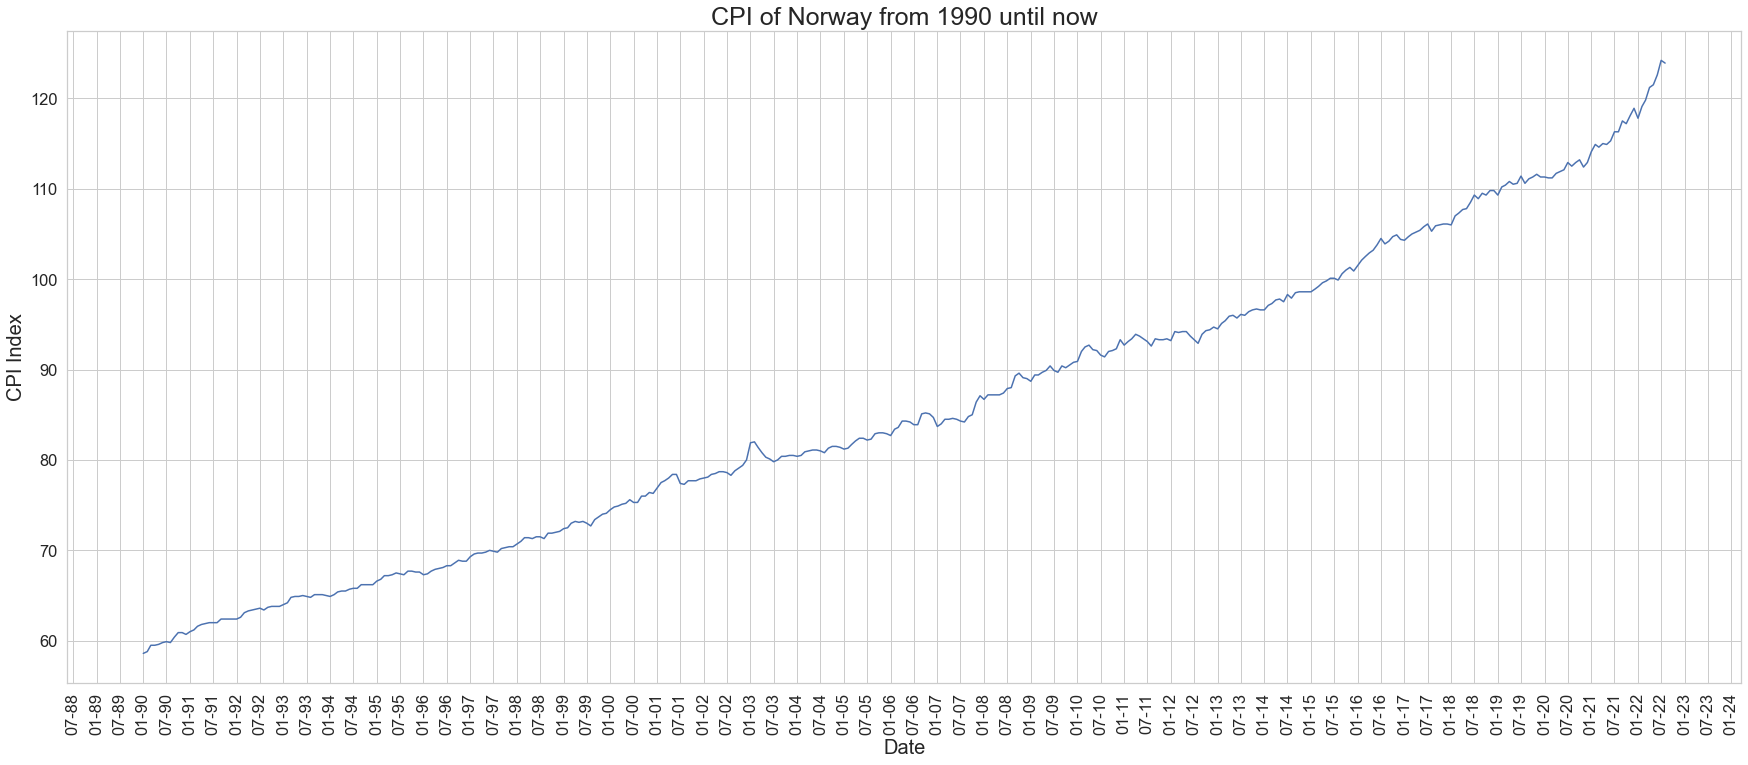

In [27]:
fig, ax = plt.subplots(figsize=(30, 12))
sns.set(font_scale=1.5, style="whitegrid")
plt.plot(df.index, df[country])
date_form = DateFormatter("%m-%y")
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation='vertical')
plt.xlabel('Date', fontdict=dict(size=20))
plt.ylabel('CPI Index', fontdict=dict(size=20))
plt.title(f'CPI of {country} from 1990 until now', fontdict=dict(size=25))
plt.savefig(os.path.join('images', 'original-ts.png'))
plt.show()


In a first analysis of the time series (TS), it's clearly seen a increasing trend of the CPI values over time. On a closer look, the TS appears to have a repetition (seasonality) every 6 months. With the increasing trend and seasonality every 6-months, it can be concluded that the original TS is not stationary. Therefore, it should be transformed to become stationary in order to apply forecasting models.

## First look at stationary by statistical test

The Dickey-Fuller (DF) unit root test is a statistical test that assesses the existence of this unit root. The test null and alternative hypotheses are:
  - H0 (𝜙 = 1): a unit root is present in a time series sample (non-stationary TS) 
  - H1 (𝜙 < 1): a unit root is not present in a time series sample (stationary TS)

In [28]:
adf_test(ts)

ADF Statistic: 2.838848
p-value: 1.000000
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


Since the p-value from the DF test is higher than 0.05, the null hypothesis cannot be rejected, meaning that the original TS is non-stationary.

## Decomposition models

As the magnitude of the time series (TS) does not seem to change over time, it will be used an additive model

    x(n) = tr(n) + sn(n) + e(n)

 tr - trend component
 sn - seasonal component
 e = erratic component

## Check trend

In [11]:
T = 12

In [12]:
months = np.arange(len(ts))

In [13]:
## trend
coefs_1d = np.polyfit(months, np.array(ts), deg=1)
values_1d = np.polyval(coefs_1d, months)
ts_1d = pd.Series(values_1d, index=ts.index, name='Linear Fit')

coefs_2d = np.polyfit(months, np.array(ts), deg=2)
values_2d = np.polyval(coefs_2d, months)
ts_2d = pd.Series(values_2d, index=ts.index, name='Quadratic Fit')

coefs_3d = np.polyfit(months, np.array(ts), deg=3)
values_3d = np.polyval(coefs_3d, months)
ts_3d = pd.Series(values_3d, index=ts.index, name='Cubic Fit')

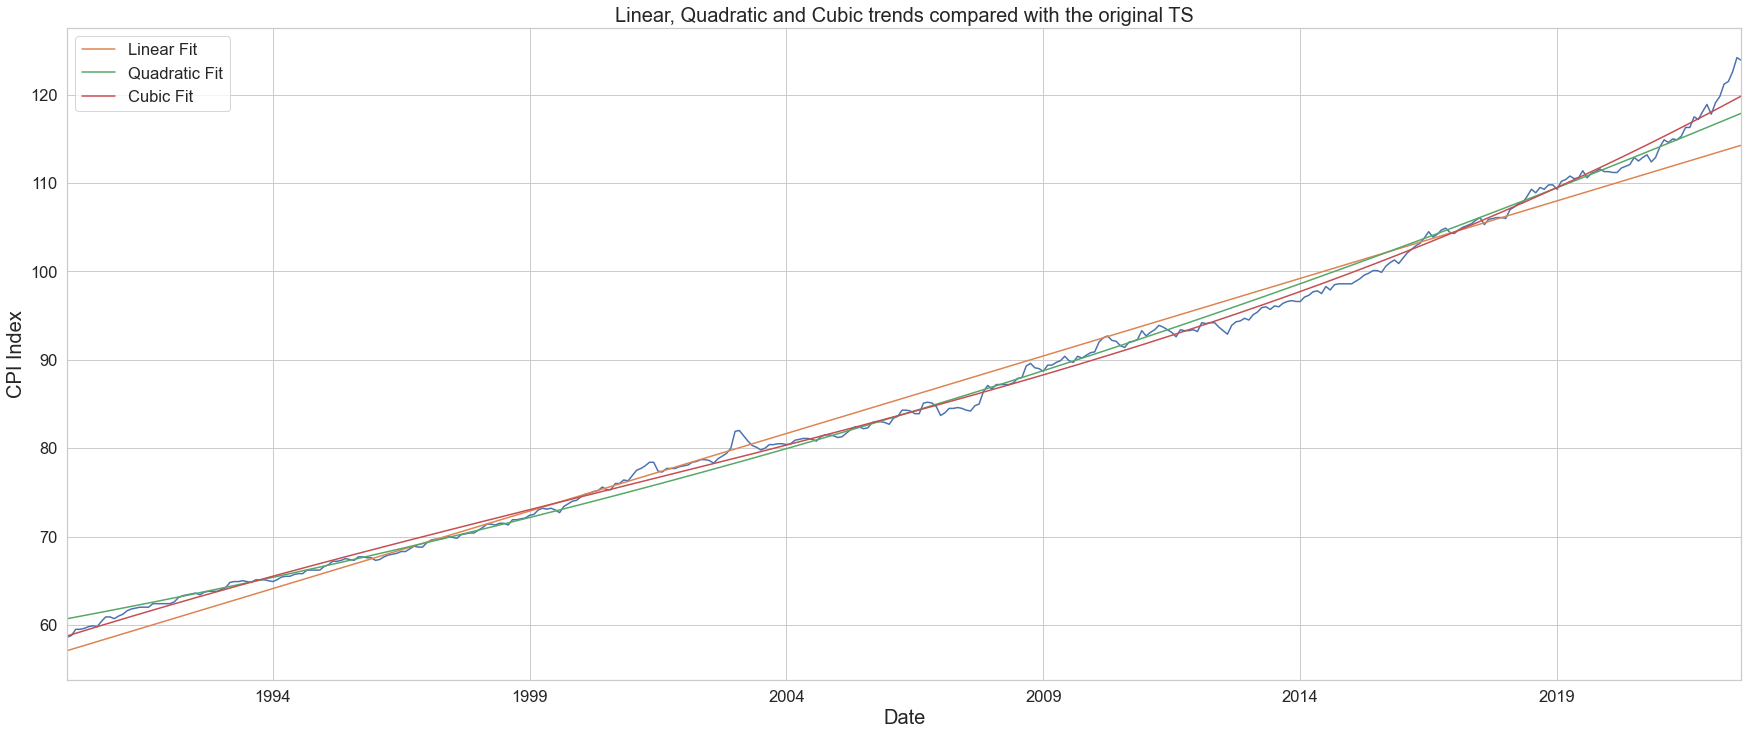

In [14]:
ax = ts.plot(figsize=(30, 12))
ts_1d.plot(ax=ax, legend=True)
ts_2d.plot(ax=ax, legend=True)
ts_3d.plot(ax=ax, legend=True)
ax.set_xlabel('Date', fontdict=dict(size=20))
ax.set_ylabel('CPI Index', fontdict=dict(size=20))
ax.set_title('Linear, Quadratic and Cubic trends compared with the original TS', fontdict=(dict(size=20)))
plt.savefig(os.path.join('images', 'trends-plot.png'))
plt.show()

After analyzing the results of plotting the original time series (TS) against the linear, quadratic and cubic trends, it was observed that the cubic trend is the that most adjusts to the data.

In [15]:
trend_adjusted = ts - ts_3d
trend = ts_3d
trend_adjusted.name = 'Trend Adjusted'

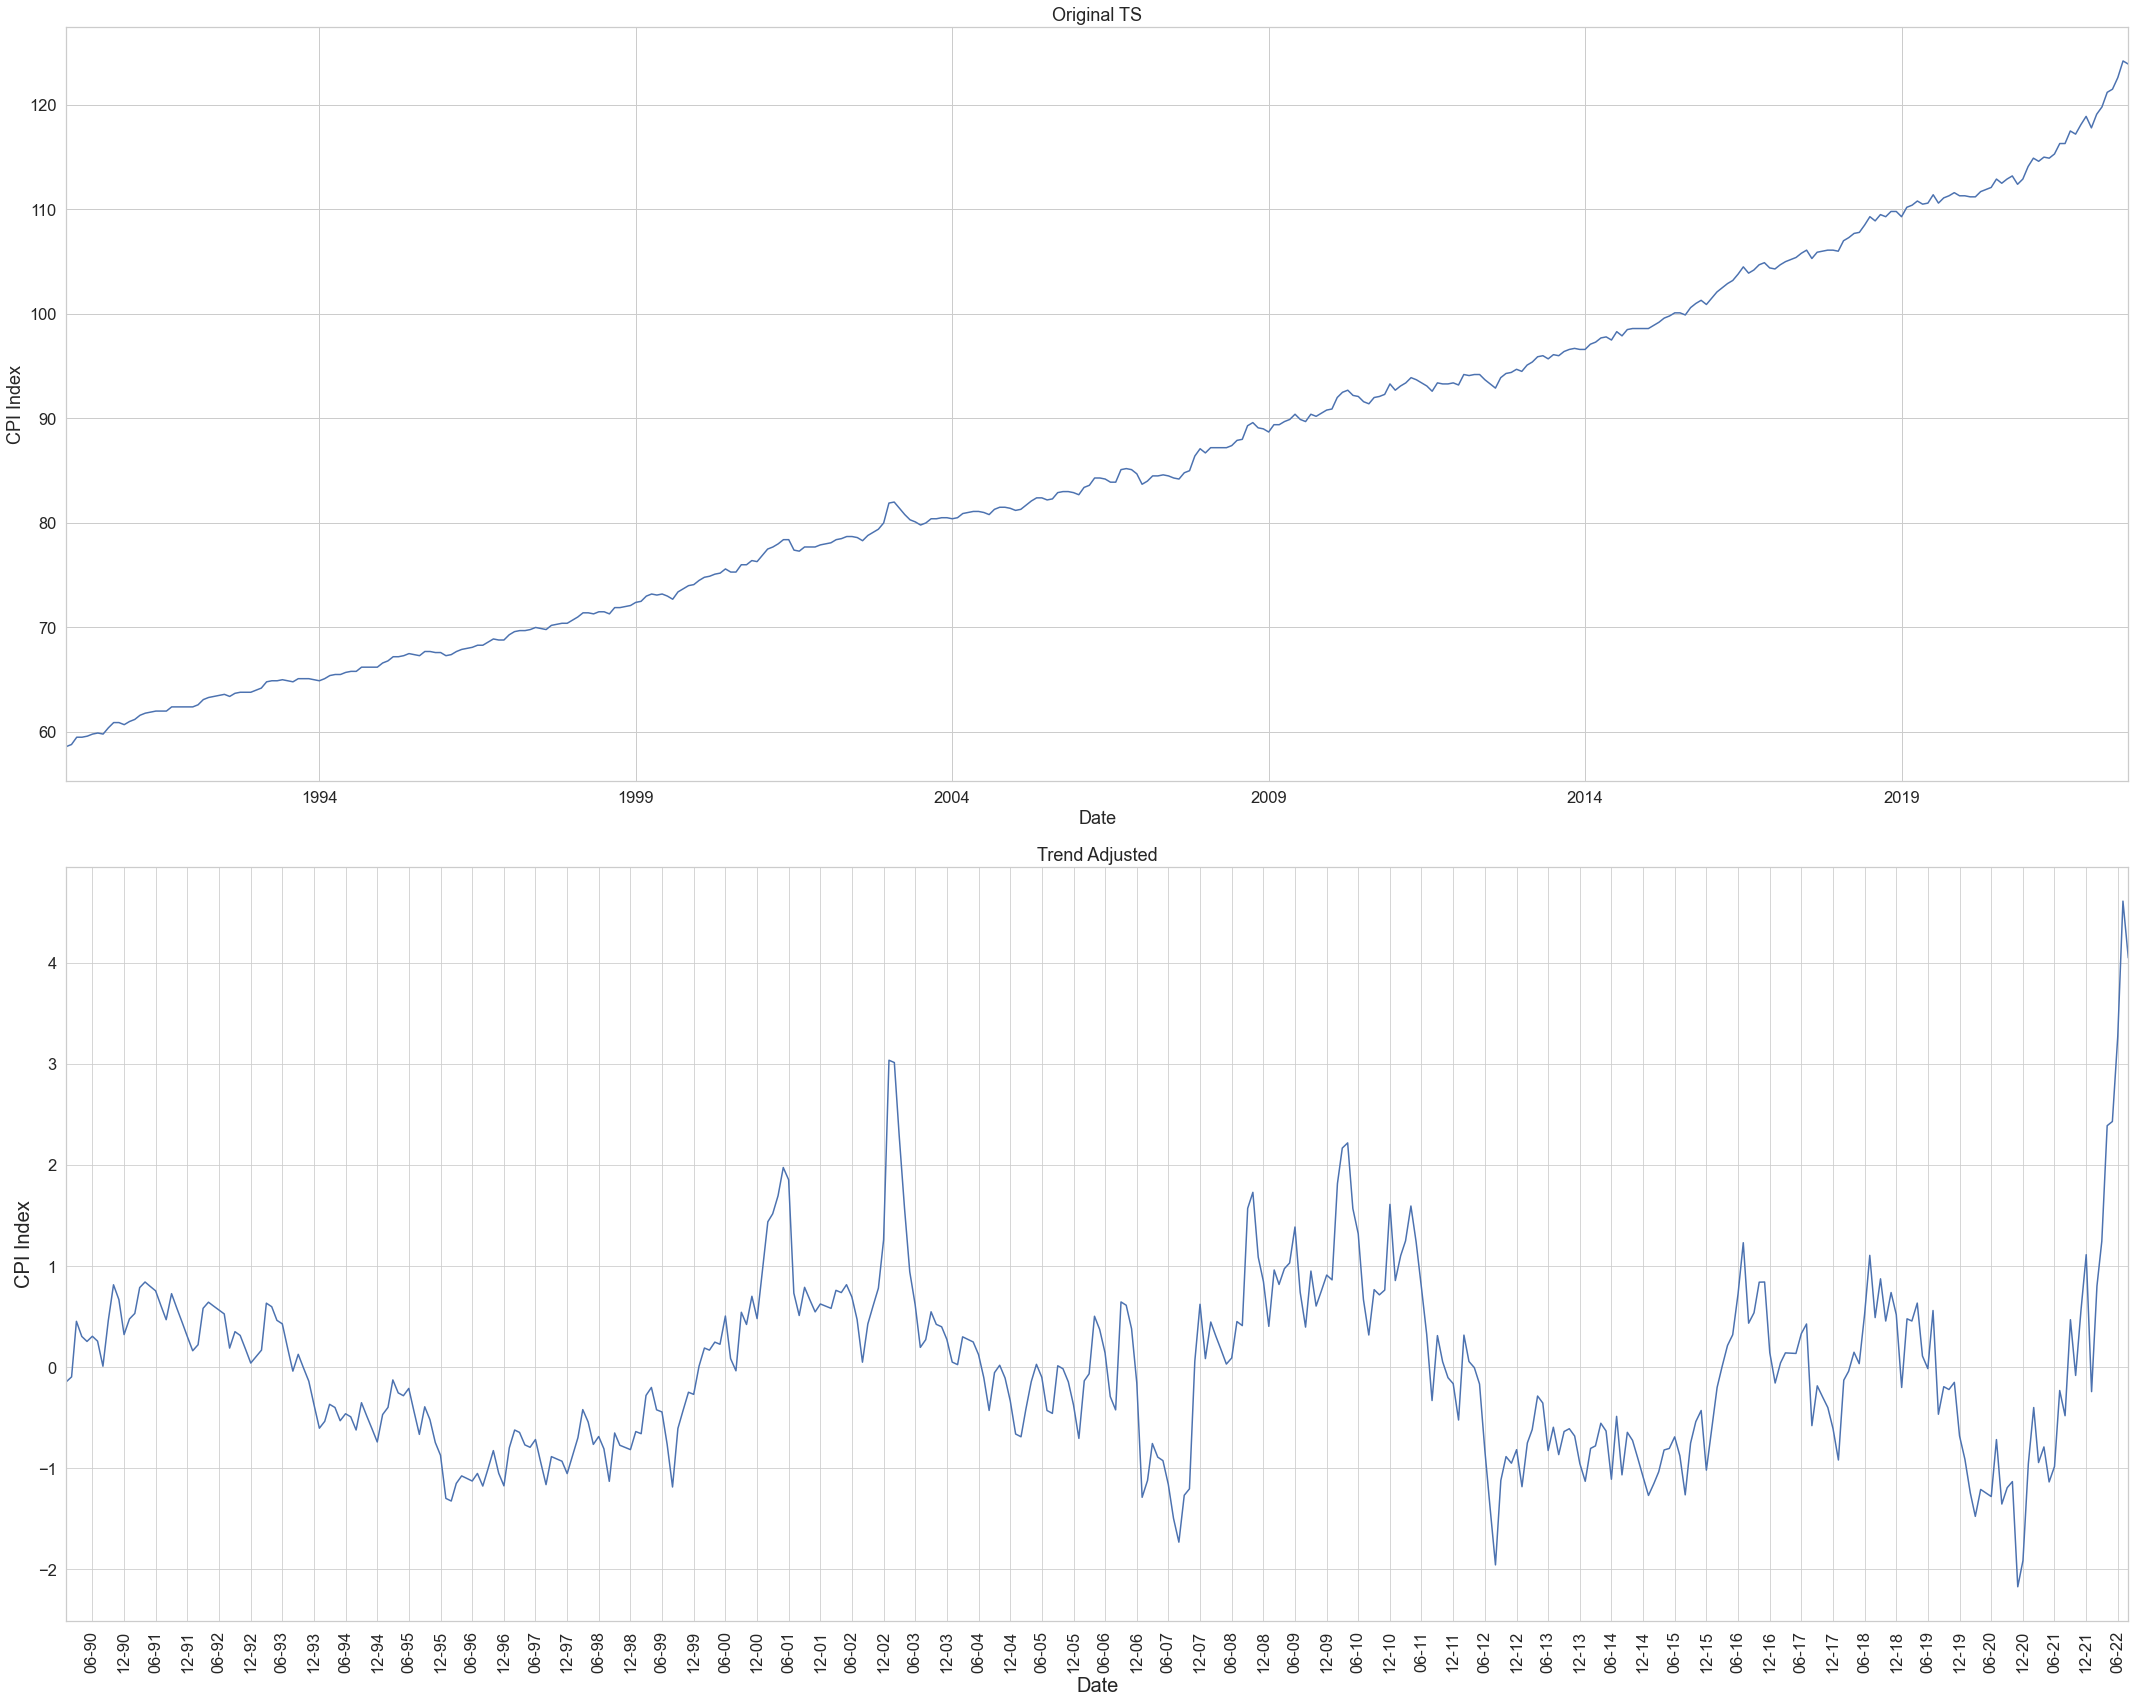

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(30, 24))
ts.plot(ax=axs[0])
axs[0].set_ylabel('CPI Index')
axs[0].set_title('Original TS')


axs[1].plot(trend_adjusted.index, trend_adjusted)
axs[1].set_ylabel('CPI Index')
axs[1].set_title('Trend Adjusted TS')
date_form = DateFormatter("%m-%y")
axs[1].xaxis.set_major_formatter(date_form)
axs[1].grid(True)
axs[1].grid(which='minor', alpha=0.3)
axs[1].grid(which='major', alpha=0.8)
axs[1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axs[1].set_xlim(ts.index[0], ts.index[-1])
plt.xticks(rotation='vertical')
plt.xlabel('Date', fontdict=dict(size=20))
plt.ylabel('CPI Index', fontdict=dict(size=20))
axs[1].set_title('Trend Adjusted')
plt.savefig(os.path.join('images', 'trend-adjusted.png'))
plt.tight_layout()
plt.show()

After adjusting the TS to the trend, the seasonal patterns appear more clearly. Each 6-month interval contains a peak more or less in the middle. At the same time, it can be seen a bigger pattern that repeat each +-7 years.

## Seasonality

In [17]:
minor_ticks = np.linspace(0, 6, 61)

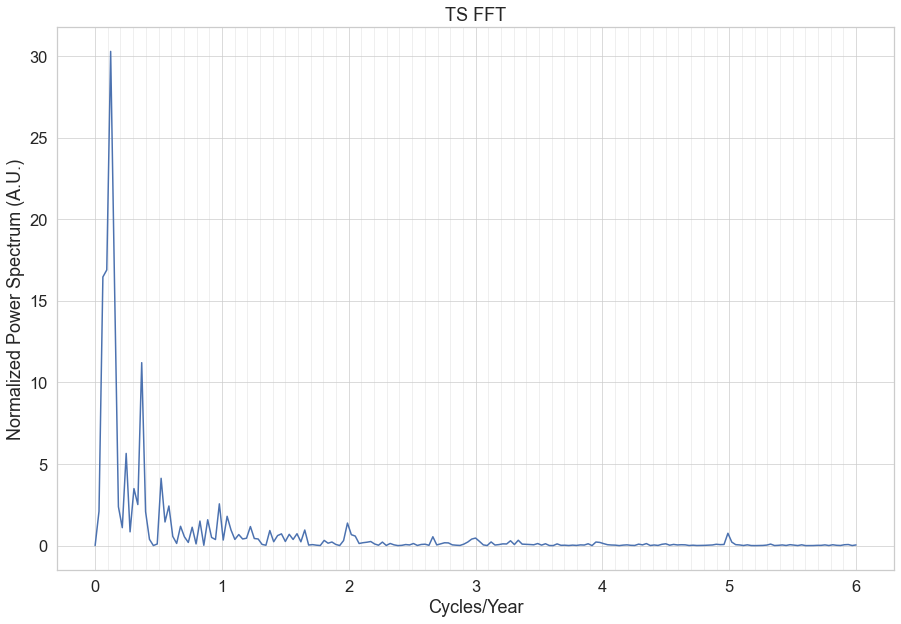

In [18]:
fTS=(np.abs(np.fft.rfft(trend_adjusted-trend_adjusted.mean()))**2/trend_adjusted.size)
sample_freq = 12 # 12 samples per year

f = np.fft.rfftfreq(trend_adjusted.size, d=1/sample_freq)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(f,fTS)
ax.set_xticks(minor_ticks, minor=10)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.3)
ax.grid(which='major', alpha=0.7)
plt.xlabel("Cycles/Year")
plt.ylabel("Normalized Power Spectrum (A.U.)")
plt.title('TS FFT')
plt.savefig(os.path.join('images', 'original_ts_fft.png'))
plt.show()

Analyzing the frequency distributions, it can confirm the previous seasonality patterns observed ever each 6 months and every 5 years, not the previous 7 years. However, it also appeared new patters every month and every 3 months and every 2 years.

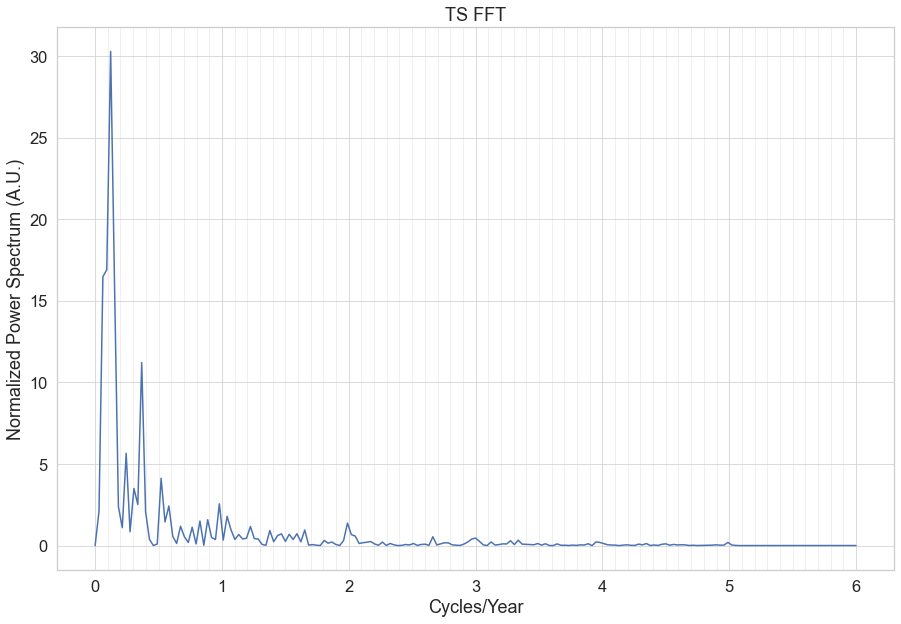

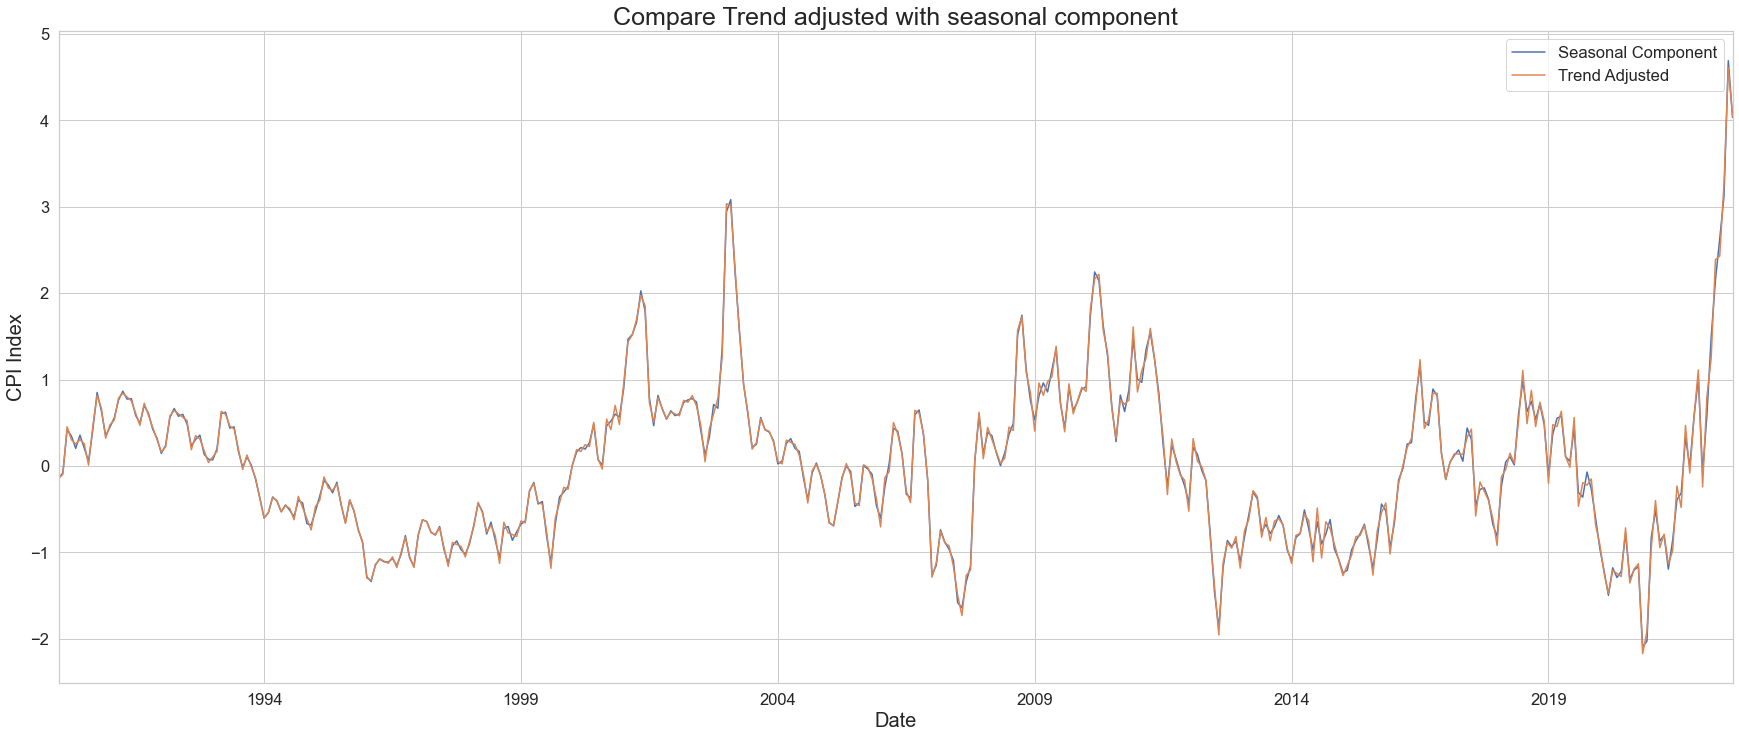

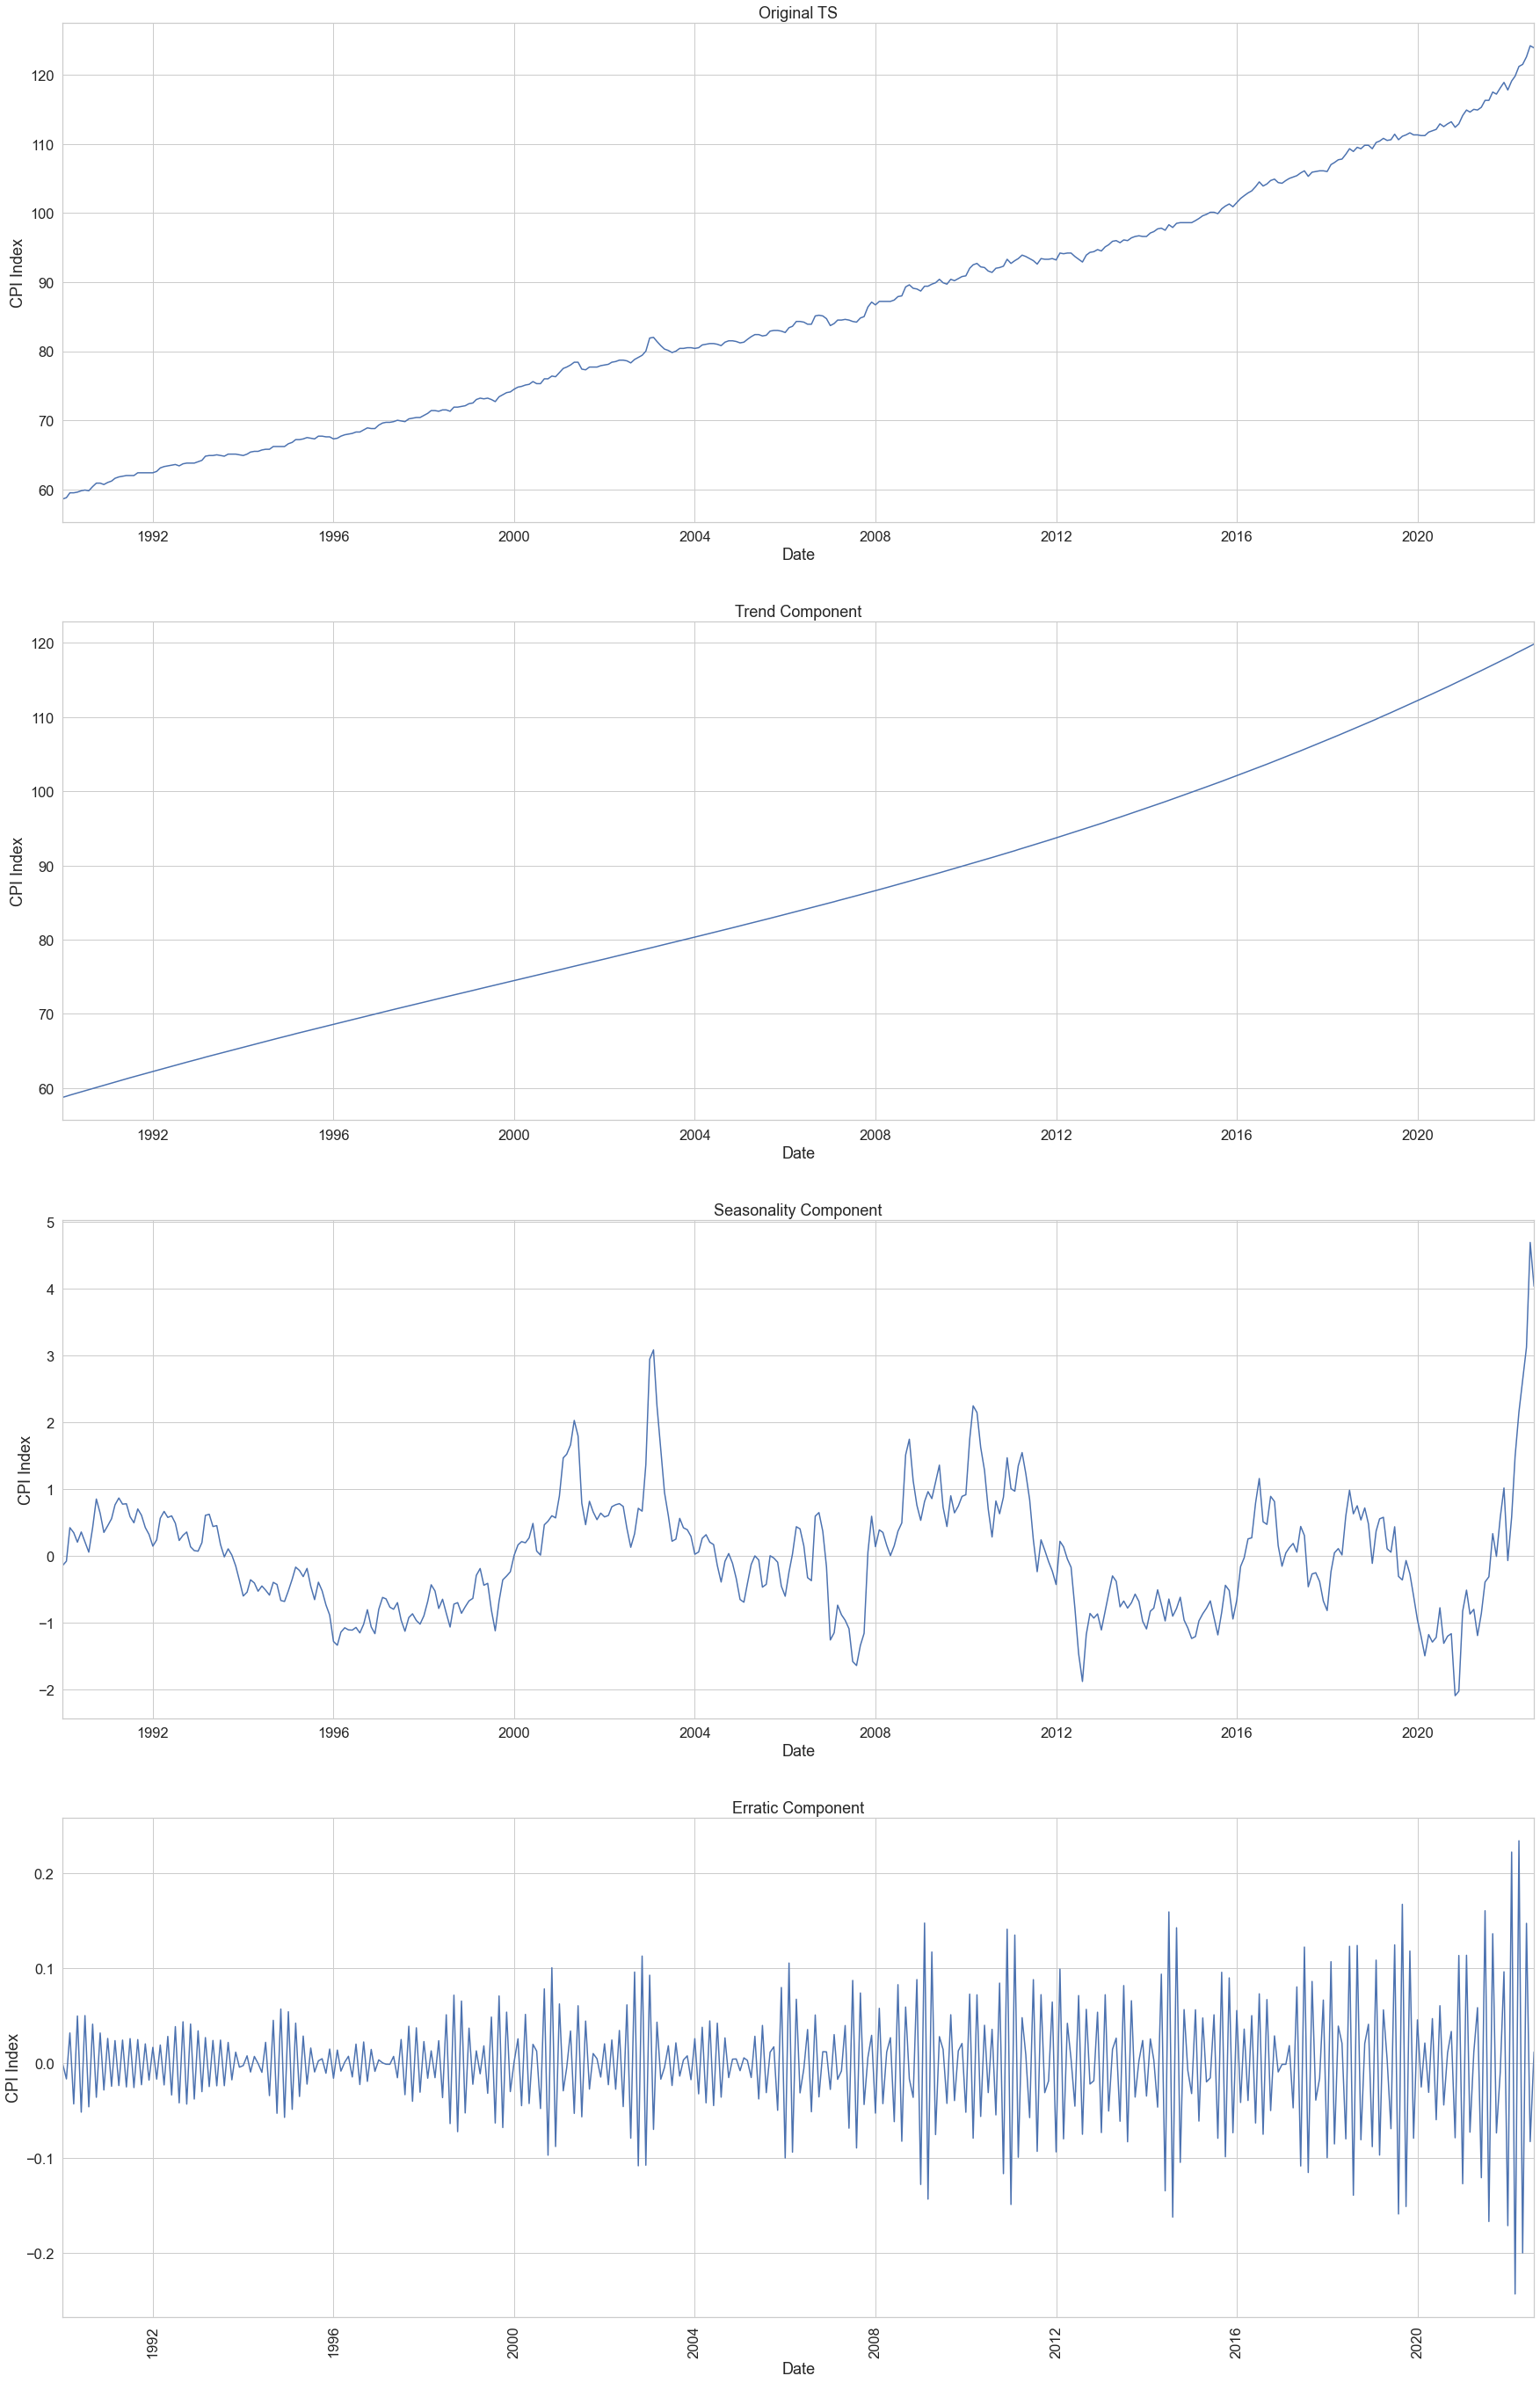

In [19]:
sos = scs.butter(N=5, fs=sample_freq, Wn=[5], btype='lowpass', output='sos')
seasonal = scs.sosfiltfilt(sos, trend_adjusted)
#Lets look at the filter effect
fTS=(np.abs(np.fft.rfft(seasonal-np.mean(seasonal)))**2/trend_adjusted.size)# Mean was subtracted because 

f = np.fft.rfftfreq(trend_adjusted.size, d=1/sample_freq)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(f,fTS)
ax.set_xticks(minor_ticks, minor=10)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.3)
ax.grid(which='major', alpha=0.7)
plt.xlabel("Cycles/Year")
plt.ylabel("Normalized Power Spectrum (A.U.)")
plt.title('TS FFT')
plt.savefig(os.path.join('images', 'filtered_ts_fft.png'))
plt.show()


seasonal_ts = pd.Series(data=seasonal, index=ts.index, name='Seasonal Component')

fig, ax = plt.subplots(1, 1, figsize=(30, 12))
seasonal_ts.plot(ax=ax, legend=True)
trend_adjusted.plot(ax=ax, legend=True)
plt.xlabel('Date', fontdict=(dict(size=20)))
plt.ylabel('CPI Index', fontdict=(dict(size=20)))
plt.title('Compare Trend adjusted with seasonal component', fontdict=(dict(size=25)))
plt.savefig(os.path.join('images', 'seasonality_adjusted.png'))
plt.show()

# remove seasonality
trend_seasonal_adjusted = trend_adjusted - seasonal_ts
trend_seasonal_adjusted.name = 'Trend and seasonality adjusted'

fig, axs = plt.subplots(4, 1, figsize=(30, 12*4))
axs[0].plot(ts.index, ts)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('CPI Index')
axs[0].set_title('Original TS')
axs[0].set_xlim(ts.index[0], ts.index[-1])

axs[1].plot(trend.index, trend)
axs[1].set_xlabel('Date')
axs[1].set_ylabel('CPI Index')
axs[1].set_title('Trend Component')
axs[1].set_xlim(trend.index[0], trend.index[-1])

axs[2].plot(seasonal_ts.index, seasonal_ts)
axs[2].set_xlabel('Date')
axs[2].set_ylabel('CPI Index')
axs[2].set_title('Seasonality Component')
axs[2].set_xlim(seasonal_ts.index[0], seasonal_ts.index[-1])

axs[3].plot(trend_seasonal_adjusted.index, trend_seasonal_adjusted)
axs[3].set_xlabel('Date')
axs[3].set_ylabel('CPI Index')
axs[3].set_title('Erratic Component')
plt.xticks(rotation='vertical')
axs[3].set_xlim(trend_seasonal_adjusted.index[0], trend_seasonal_adjusted.index[-1])
plt.savefig(os.path.join('images', 'additive_model_components.png'))
plt.show()


## Trend and seasonal removal by differentiation

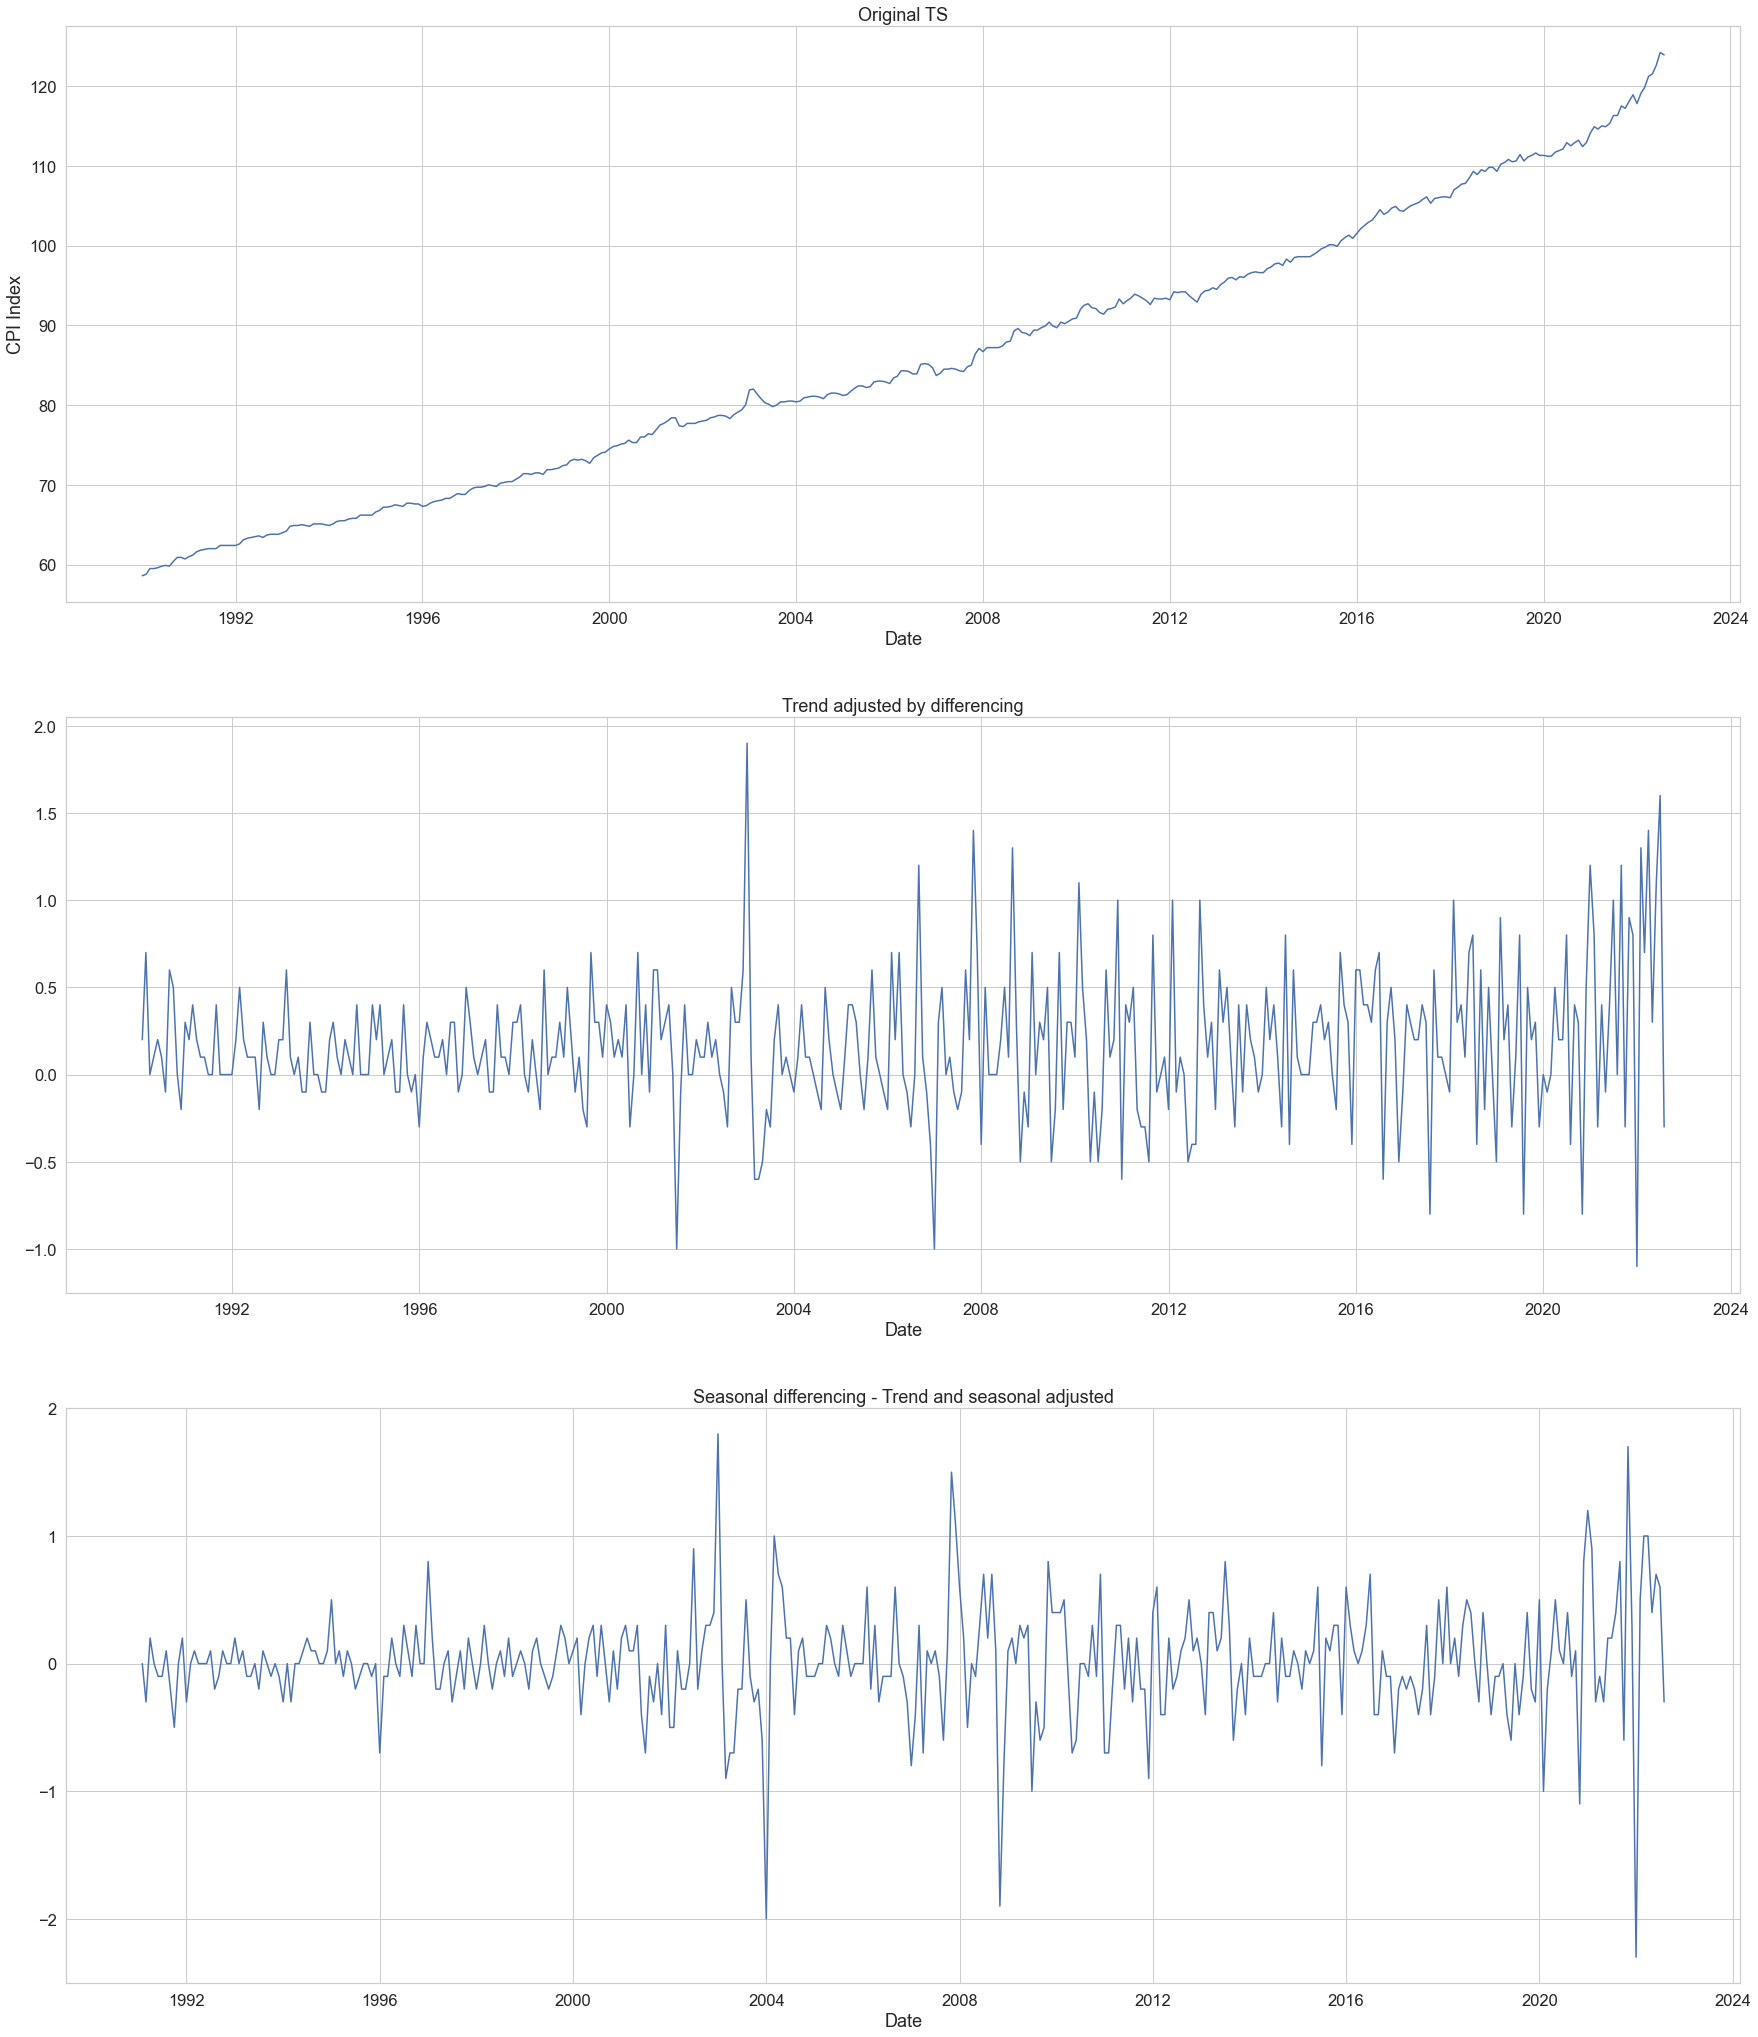

In [20]:
trend_adjusted_diff = ts.diff()

trend_seasonal_adjusted_diff = trend_adjusted_diff.diff(12) # because T = 12, samples colleted each month and yearly

fig, axs = plt.subplots(3, 1, figsize=(30, 12*3))

axs[0].plot(ts.index, ts)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('CPI Index')
axs[0].set_title('Original TS')

axs[1].plot(trend_adjusted_diff.index, trend_adjusted_diff)
axs[1].set_xlabel('Date')
axs[1].set_title('Trend adjusted by differencing')

axs[2].plot(trend_seasonal_adjusted_diff.index, trend_seasonal_adjusted_diff)
axs[2].set_xlabel('Date')
axs[2].set_title('Seasonal differencing - Trend and seasonal adjusted')
plt.show()

## Statistical test to check stationary

### Trend and seasonal adjusted by model-fitting and filtering

In [21]:
adf_test(trend_seasonal_adjusted)

ADF Statistic: -23.447080
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


Based on the ADF test, given the p-value of 0.0, the transformed TS is stationary.

### Trend and seasonal adjusted by differencing

In [22]:
adf_test(trend_seasonal_adjusted_diff.dropna())

ADF Statistic: -7.029147
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


By the Dickey-Fuller test, after differencing the resulted TS is stationary. However, the ADF statistic most closer to the critical values than when the TS is decomposed by model-fitting and filtering. 

## ACS to see stationary

In [23]:
def auto_covarience_aux(ts, T=0):
    N = len(ts)
    mean = ts.mean()
    cov_coef = 0
    for n in range(N-T-1): ## Não estaremos a retirar um a mais
        cov_coef += (ts[n] - mean) * (ts[n+T]-mean)
    return cov_coef / N


def auto_covarience(ts, T=0):
    return auto_covarience_aux(ts, T) / auto_covarience_aux(ts)


def correlogram(ts, max_T, twoside=False):
    N = len(ts)
    if twoside:
        corrl = np.zeros(2 * max_T + 1)
        index = np.arange(max_T + 1)
        index = np.concatenate((-np.flip(index[1:]), index), axis=0)
    else:
        corrl = np.zeros(max_T)
        index = np.arange(max_T)

    for i in range(max_T):
        if twoside:
            corrl[max_T + i] = auto_covarience(ts, i)
            corrl[max_T - i] = corrl[max_T + 1]
        else:
            corrl[i] = auto_covarience(ts, i)
    
    d = {'ACS':corrl, 'upper_CB':np.ones(max_T)*(1.96/np.sqrt(N)),'lower_CB':-np.ones(max_T)*(1.96/np.sqrt(N))}
    return pd.DataFrame(data=d, index=index)

In [24]:
def plot_correlogram(ts, title):
    corrl = correlogram(ts, len(ts))
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.stem(corrl.index, corrl.ACS, label='ACS')
    ax.plot(corrl.index, corrl.upper_CB, linestyle='--', color='r', linewidth=2, label='+/-1.96/sqrt(N)'),
    ax.plot(corrl.index, corrl.lower_CB, linestyle='--', color='r', linewidth=2),
    plt.title(title)
    plt.legend()
    plt.ylabel('Autocorrelation')
    plt.xlabel('T')

/var/folders/7x/f99kq48n5_7cdmmy6sz268nw0000gn/T/ipykernel_37821/2600244812.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cov_coef += (ts[n] - mean) * (ts[n+T]-mean)


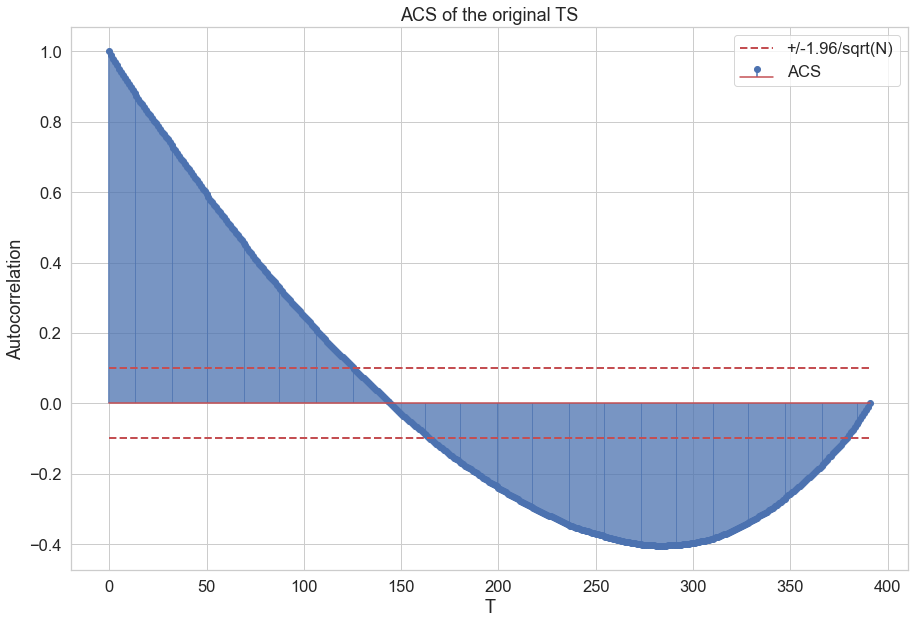

In [25]:
plot_correlogram(ts, 'ACS of the original TS')

From the ACS plot, it can be confirm the previous claim that the original time series isn't stationary as the ACS have significant values for T > 0, using a significance level of 95%.

/var/folders/7x/f99kq48n5_7cdmmy6sz268nw0000gn/T/ipykernel_37821/2600244812.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cov_coef += (ts[n] - mean) * (ts[n+T]-mean)


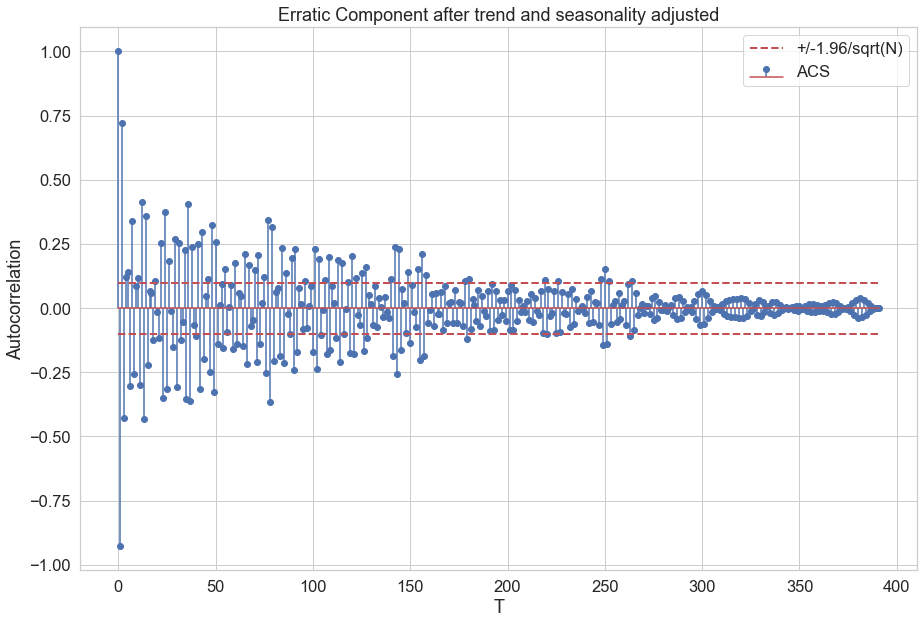

In [26]:
plot_correlogram(trend_seasonal_adjusted, 'Erratic Component after trend and seasonality adjusted')

Looking at the ACS, there is a rapid decreasing of the values, which can indicate that the erratic component is stationary